# Calibrating the number of iterations ($i_{\max}$) to run GRASP

In [1]:
import pandas as pd
from grasp_iters import read_results

names = [
    "rat783_522_261_0_p20_a2", # 0
    "rat783_522_261_0_p20_a3",
    "rl1323_882_441_0_p20_a2", # 2
    "rl1323_882_441_0_p20_a3",
    "anpcp_882_441_0_p20_a2",  # 4
    "anpcp_882_441_0_p20_a3",
]
name = names[1]

iters = read_results(name)

iters

,iter,beta,RGD_OF,AFVS_OF,time,is_new_best
0,0,0.431009,163,142,0.363193,True
1,1,0.560308,204,165,1.313487,False
2,2,0.453275,165,130,2.130528,True
3,3,0.378322,165,128,2.959331,True
4,4,0.504873,218,156,3.706425,False
...,...,...,...,...,...,...
4995,4995,0.427825,170,150,3248.174261,False
4996,4996,0.187768,179,165,3248.439009,False
4997,4997,0.218076,171,142,3248.954140,False
4998,4998,0.454904,192,150,3250.097544,False


In [2]:
# iters["time"].diff()

In [3]:
def get_improvs(iters_df: pd.DataFrame):
    improvs = iters_df[iters_df["is_new_best"] == True].drop("is_new_best", axis=1)

    # multiplication is negative because the problem is a minimization problem,
    # a decrease in the objective function (a negative percent change) means a better solution
    percents = improvs["AFVS_OF"].pct_change().mul(-100)
    improvs.insert(loc=4, column="imp", value=percents)

    # iterations without improvement (iwi)
    iter_diffs = improvs["iter"].diff().fillna(0).astype(int)
    improvs.insert(loc=6, column="iwi", value=iter_diffs)

    return improvs

In [4]:
improvs = get_improvs(iters)
improvs

,iter,beta,RGD_OF,AFVS_OF,imp,time,iwi
0,0,0.431009,163,142,NaN,0.363193,0
2,2,0.453275,165,130,8.450704,2.130528,2
3,3,0.378322,165,128,1.538462,2.959331,1
8,8,0.308022,174,126,1.562500,7.595635,5
77,77,0.103021,164,125,0.793651,44.869983,69
96,96,0.592382,161,122,2.400000,57.602794,19
2227,2227,0.453959,172,120,1.639344,1472.833561,2131
2342,2342,0.315168,172,118,1.666667,1542.065478,115


In [5]:
from utils import format_latex_table

format_latex_table(improvs, f"nb_results\\grasp\\iters_improvs_{name}.tex");

c:\Users\netoo\local-personal\repos\alpha-neighbor-p-center-problem\anpcp\utils.py:104: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dataframe.to_latex(path, float_format="%.2f", multirow=True)


In [10]:
import matplotlib.pyplot as plt

def plot_improvs(
    iters_df: pd.DataFrame,
    lastimprov: int,
    annotation_xdiff: int,
    annotation_ydiff: int,
    color: str = "blue",
    filename: str = ""
):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
    
    ax.plot(
        iters_df["iter"][:lastimprov],
        iters_df["AFVS_OF"].cummin()[:lastimprov],
        color=color,
    )

    for _, row in improvs.iterrows():
        of = int(row["AFVS_OF"])
        i = int(row["iter"])
        percent = row["imp"]

        ax.annotate(
            f"x(S) = {of}",
            (i, of),
            xytext=(i + annotation_xdiff, of + annotation_ydiff),
        )

    ax.set_title(f"Improvements in $S$ during GRASP")
    ax.set_ylabel("$x(S)$")
    ax.set_xlabel("Iteration")

    if filename:
        fig.savefig(filename, bbox_inches="tight")
    else:
        plt.show()

Manually adjust parameters to plot each instance

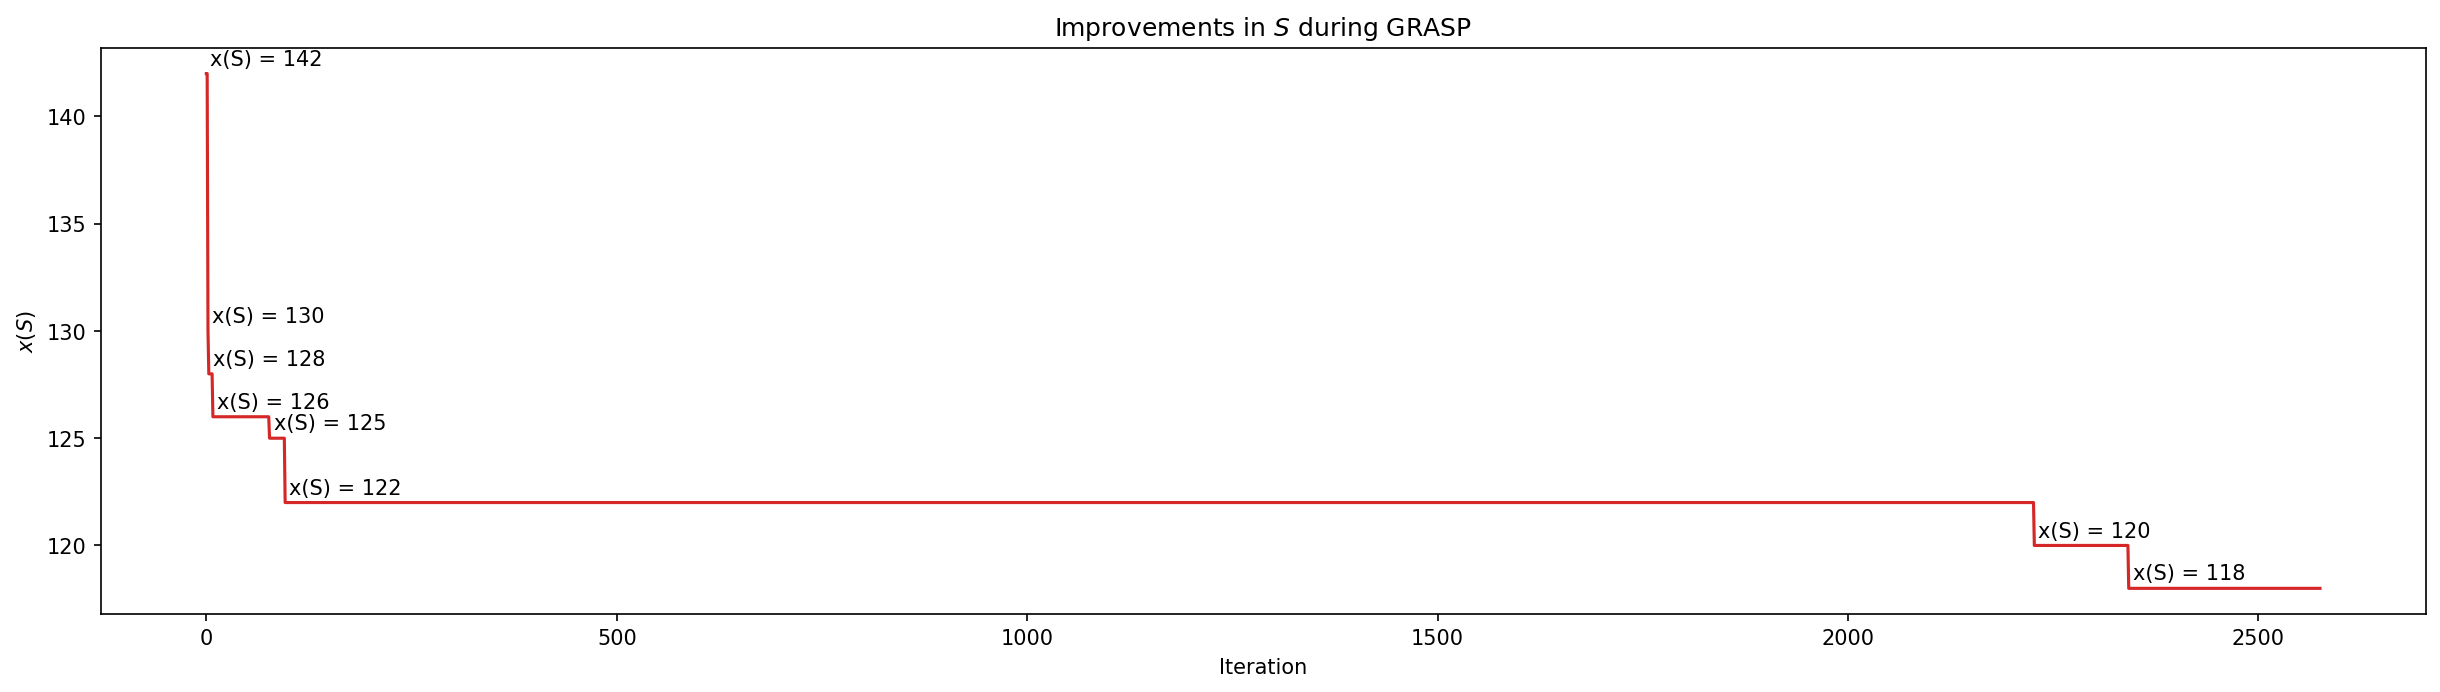

In [14]:
plot_improvs(
    iters, 2576, 5, 0.4, "tab:red",
    f"nb_results\\grasp\\iters_plot_{name}.png"
)

In [8]:
2342 * 1.1

2576.2000000000003